# 1 - Importation

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
import seaborn as sns

import folium
from folium.plugins import MarkerCluster
from scipy.spatial import cKDTree

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb

In [2]:
# Viualisation options to put here
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 350)

In [3]:
train = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/train.csv')
gas_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/gas_prices.csv')
elec_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/electricity_prices.csv')
weather_forecast = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/forecast_weather.csv')
station = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/final_county_mapping.csv.xls')
client = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/client.csv')
weather_hist = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/historical_weather.csv')

In [4]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


# 2 - Functions definition

## 2.1 - Preprocessing

In [398]:
def convert_datetime_hours(df):
    '''Convert a specified date column in a DataFrame to datetime format, including the hour component.
    Rename the date column if the name is not datetime.
    '''
    print('Start converting datetime type columns which include hour component ⏳')

    columns_df = df.columns

    if 'datetime' in columns_df:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

    elif 'forecast_date' in columns_df:
        df['forecast_date'] = pd.to_datetime(df['forecast_date'], format='%Y-%m-%d %H:%M:%S')
        df.rename(columns={'forecast_date':'datetime'}, inplace=True)

    elif 'date' in columns_df:
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df.rename(columns={'date':'datetime'}, inplace=True)

    elif 'forecast_datetime' in columns_df:
        df['date'] = pd.to_datetime(df['forecast_datetime'], format='%Y-%m-%d %H:%M:%S')
        df.rename(columns={'forecast_datetime':'datetime'}, inplace=True)

    elif 'prediction_datetime' in columns_df:
        df['date'] = pd.to_datetime(df['prediction_datetime'], format='%Y-%m-%d %H:%M:%S')
        df.rename(columns={'prediction_datetime':'datetime'}, inplace=True)

    print('Datetime column converted ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return df

In [399]:
def convert_datetime_day(df):
    '''Convert a specified date column in a DataFrame to datetime format with day component but no hour component.
    Rename the date column if the name is not datetime.
    '''
    print('Start converting datetime type columns wich doesnt include hour component ⏳')

    columns_df = df.columns

    if 'datetime' in columns_df:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')

    elif 'forecast_date' in columns_df:
        df['forecast_date'] = pd.to_datetime(df['forecast_date'], format='%Y-%m-%d')
        df.rename(columns={'forecast_date':'datetime'}, inplace=True)

    elif 'date' in columns_df:
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df.rename(columns={'date':'datetime'}, inplace=True)

    elif 'forecast_datetime' in columns_df:
        df['date'] = pd.to_datetime(df['forecast_datetime'], format='%Y-%m-%d')
        df.rename(columns={'forecast_datetime':'datetime'}, inplace=True)

    elif 'prediction_datetime' in columns_df:
        df['date'] = pd.to_datetime(df['prediction_datetime'], format='%Y-%m-%d')
        df.rename(columns={'prediction_datetime':'datetime'}, inplace=True)

    print('Datetime column converted ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return df

In [400]:
def add_county_localization (df_to_complete, df_with_station):
    ''' Add county column to dataset with only latitude and longitude columns to merge datasets more easily
    '''
    print('Start adding a county column to the dataset 🌎')

    tree = cKDTree(df_with_station[['latitude', 'longitude']].values)

    # For each point in the dataset, find the nearest point in the station dataset.
    distances, indices = tree.query(df_to_complete[['latitude', 'longitude']].values)

    # Add city name to weather_hist dataset
    df_to_complete['county'] = df_with_station.loc[indices, 'county'].values

    print('County column added ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df_to_complete

In [431]:
def merge_data (df_main, df_weather_hist, df_weather_forecast, df_elec, df_gas, df_station, df_client):
    '''Merge all datasets together
    '''
    print('Start merging all the datasets together 🛠️')

    # Add county to the weather dataset so that we can merge easier
    df_weather_hist_with_county = add_county_localization(df_weather_hist, df_station)
    df_weather_forecast_with_county = add_county_localization(df_weather_forecast, df_station)

    #Be sure that the datasets have datetime format
    df_weather_forecast_with_county = convert_datetime_hours(df_weather_forecast_with_county)
    df_weather_hist_with_county = convert_datetime_hours(df_weather_hist_with_county)
    df_client = convert_datetime_day(df_client)
    df_main = convert_datetime_hours(df_main)

    # Merge gas data and main data
    df_gas.drop(columns=['origin_date','data_block_id'],inplace=True)
    df_merged = df_main.merge(df_gas, on='datetime', how='left')
    print('Main dataset and gas dataset merged ✅')

    #Merge client data and main data
    df_client.drop(columns='data_block_id',inplace=True)
    df_merged1 = df_merged.merge(df_client, on=['datetime','county','is_business','product_type'], how='left')
    print('Main dataset and clients dataset merged ✨')

    # Merge elec data and main data
    df_elec.drop(columns=['origin_date','data_block_id'], inplace=True)
    df_merged2 = df_merged1.merge(df_elec, on='datetime', how='left')
    print('Main dataset and elec dataset merged ✨')

    # Group weather data and merge with the main data
    weather_hist_grouped = df_weather_hist_with_county.groupby(['datetime','county']).mean()
    weather_forecast_grouped = df_weather_forecast_with_county.groupby(['datetime','county']).mean()

    weather_hist_grouped.drop(columns='data_block_id', inplace=True)
    df_merge4 = df_merged2.merge(weather_hist_grouped, on=['datetime','county'], how='left')
    print('Main dataset and weather historical dataset merged ✨')

    weather_forecast_grouped.drop(columns='data_block_id', inplace=True)
    df_merge5 = df_merge4.merge(weather_forecast_grouped, on=['datetime','county'], how='left')
    print('Main dataset and forecast  dataset merged ✨')

    assert df_merge5.shape[0] == df_main.shape[0], f'Main df rows:{df_main.shape[0]} and Output rows:{df_merge5.shape[0]}'

    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df_merge5

In [402]:
def add_date_features (df):
    '''Add basic date features to the dataset
    '''
    print('Start adding date features to the dataset 📅')

    # Setting up date index
    df['date'] = df['datetime'].dt.date
    df.set_index('datetime',inplace=True)

    # Add basic features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.weekofyear
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    print('Basic date features added ✅')

    # Add cyclical features
    df['month_cyclical'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))
    df['week_cyclical'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 7))
    df['year_cyclical'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 365))
    df['hour_cyclical'] = df['month'].apply(lambda x: np.sin(2 * np.pi * x / 24))
    print('Cyclical features added ✅')

    # Add season features
    df['season'] = 0
    df.loc[df['month'].isin([3, 4,5]), 'season'] = 2 #spring
    df.loc[df['month'].isin([6, 7,8]), 'season'] = 3 #summer
    df.loc[df['month'].isin([9, 10,11]), 'season'] = 4 #fall
    df.loc[df['month'].isin([12, 1,2]), 'season'] = 1 #winter
    print('Season features added ✅')

    # Add weekend features
    df['weekend'] = 0
    df.loc[df['weekday'].isin([1,2,3,4,0]), 'weekend'] = 0
    df.loc[df['weekday'].isin([6,5]), 'weekend'] = 1
    print('Weekday features added ✅')

    # Add day and night features
    df['is_night'] = ''

    sunrise_sunset = {
        1: {'sunrise': 9, 'sunset': 16},  # January
        2: {'sunrise': 8, 'sunset': 16},  # February
        3: {'sunrise': 7, 'sunset': 19},  # March
        4: {'sunrise': 6, 'sunset': 20},  # April
        5: {'sunrise': 5, 'sunset': 21},  # Mai
        6: {'sunrise': 4, 'sunset': 23},  # June
        7: {'sunrise': 4, 'sunset': 22},  # July
        8: {'sunrise': 5, 'sunset': 21},  # August
        9: {'sunrise': 6, 'sunset': 20},  # Sept
        10: {'sunrise': 7, 'sunset': 19},  # Oct
        11: {'sunrise': 8, 'sunset': 17},  # Nov
        12: {'sunrise': 9, 'sunset': 16}   # Dec
    }

    def is_night(row):
        month = row['month']
        hour = row['hour']
        sunrise = sunrise_sunset[month]['sunrise']
        sunset = sunrise_sunset[month]['sunset']
        return 1 if hour < sunrise or hour >= sunset else 0

    df['is_night'] = df.apply(is_night, axis=1)
    print('Night or not features added ✅')

    # Add special Estonian events features
    events = {
        (2, 24): 'Independence Day',
        (4, 1): 'Labor Day',
        (6, 23): 'Victory Day',
        (6, 24): 'St. John\'s Day',
        (8, 20): 'Restoration of Independence Day',
        (12, 24): 'Christmas',
        (12, 25): 'Christmas',
        (12, 31): 'New Year\'s Eve'
    }

    # Function to check if a date corresponds to an event
    def is_event(month, day):
        return 1 if (month, day) in events else 0

    # Create a new column 'event' with 1 for special events and 0 otherwise
    df['event'] = df.apply(lambda row: is_event(row['month'], row['day']), axis=1)
    print('Special events added ✅')
    print('Data features added to the dataset ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df


In [403]:
def clean_na (df, threshold):
    '''Apply forward and backward filling method to columns with missing values above a certain threshold
    Delete rows with missing values below the same threshold.
    '''
    print('Start cleaning the missing values in the dataset 🧽')
    assert threshold > 1, 'The threshold must be in % (example: 0.8)'

    #Calculate the missing values percentage per column and store the name
    missing_percentage = df.isna().mean() * 100

    columns_with_missing_above_threshold = missing_percentage[missing_percentage >= threshold].index.tolist()
    columns_with_missing_below_threshold = missing_percentage[missing_percentage < threshold].index.tolist()

    #Complete missing values with forward and backward filling method
    for i in columns_with_missing_above_threshold:
        df[i] = df.groupby('date')[i].transform(lambda x: x.ffill().bfill())
        print(f'Column {i} cleaned ✨')

    #Delete rows with missing values below the threshold
    df = df.dropna(subset=columns_with_missing_below_threshold)

    #Delete rows with eventually missing values from the list above the threshold
    df = df.dropna(subset=columns_with_missing_above_threshold)

    print('Rows with missing values droped 👋')
    print('Data set cleaned with missing values ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df


In [404]:
def drop_useless_columns (df, threshold):
    ''' Drop columns that doesnt bring meaningfull and usefull information based on our previous EDA
    '''
    print('Start droping the useless columns in the dataset 🧽')
    assert threshold < 1, 'The threshold must be below 1'

    # Drop columns with id because they don't bring meaningfull informations
    columns_to_drop = [col for col in df.columns if '_id' in col]
    df = df.drop(columns=columns_to_drop)
    print('Columns with id dropped ✅')

    # Drop columns with high correlation
    print('Building the correlation matrix ⏳')
    correlation_matrix = df.corr().abs()

    high_corr_pairs = np.where(correlation_matrix > threshold)
    high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]

    to_drop = set()
    for pair in high_corr_pairs:
        to_drop.add(pair[1])  # Add the second item in the pair to the drop list

    df = df.drop(columns=to_drop)
    print(f'Columns ({len(to_drop)}) with correlation above {threshold} dropped ✅')

    # Drop object or Datetime columns
    df = df.reset_index()
    object_datetime_columns = df.select_dtypes(include=['object', 'datetime']).columns
    df.drop(columns=object_datetime_columns, inplace=True)
    print(f'Columns Datetime or Object type dropped ✅')

    # Drop duplicated columns
    df = df.loc[:, ~df.columns.duplicated()]
    print(f'Dupplicated columns dropped ✅')

    print('All useless columns dropped ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return df

In [512]:
def drop_useless_columns2 (df, threshold):
    ''' Drop columns that doesnt bring meaningfull and usefull information based on our previous EDA
    '''
    print('Start droping the useless columns in the dataset 🧽')
    assert threshold < 1, 'The threshold must be below 1'

    # Drop columns with high correlation
    print('Building the correlation matrix ⏳')
    correlation_matrix = df.corr().abs()

    high_corr_pairs = np.where(correlation_matrix > threshold)
    high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]

    to_drop = set()
    for pair in high_corr_pairs:
        to_drop.add(pair[1])  # Add the second item in the pair to the drop list

    #df = df.drop(columns=to_drop)
    print(f'Columns ({len(to_drop)}) with correlation above {threshold} dropped ✅')

    # Drop object or Datetime columns
    df = df.reset_index()
    object_datetime_columns = df.select_dtypes(include=['object', 'datetime']).columns
    df.drop(columns=object_datetime_columns, inplace=True)
    print(f'Columns Datetime or Object type dropped ✅')

    # Drop duplicated columns
    df = df.loc[:, ~df.columns.duplicated()]
    print(f'Dupplicated columns dropped ✅')

    print('All useless columns dropped ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return df

In [406]:
def clean_na2 (df, threshold):
    '''Apply forward and backward filling method to columns with missing values above a certain threshold
    Delete rows with missing values below the same threshold.
    '''
    print('Start cleaning the missing values in the dataset 🧽')
    assert threshold > 1, 'The threshold must be in % (example: 80%)'

    #Calculate the missing values percentage per column and store the name
    missing_percentage = df.isna().sum()

    columns_with_missing_values = missing_percentage[missing_percentage > 0].index.tolist()

    #Complete missing values with forward and backward filling method
    for i in columns_with_missing_values:
        df[i] = df.groupby('date')[i].transform(lambda x: x.ffill().bfill())
        print(f'Column {i} cleaned ✨')


    print('Data set cleaned with missing values ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)

    return df

## 2.2 - Train and predict

In [648]:
def split_set(df,split_level):
    print('Starting to split the main dataset ⏳')

    X = df.drop(columns='target')
    y = df['target']

    train_size = int(df.shape[0]*split_level)

    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]

    X_train = train_df.drop(columns='target')
    y_train = train_df['target']

    X_test = test_df.drop(columns='target')
    y_test = test_df['target']

    print('Main dataset splited ✅')
    return X, y, X_train, y_train, X_test, y_test

In [649]:
def train_lgbm(X, y, X_train, y_train, X_test, y_test):
    ''' Take X and y and then train with LGBM model.
    '''
    print('Lets start bye evaluating the current data and model ⏳')
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # LGBM params training
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'early_stopping_round': 100
    }

    # Training the model
    model_train = lgb.train(params,
                    train_data,
                    valid_sets=[test_data],
                    num_boost_round=1000)

    # Faire des prédictions
    y_pred_lgbm_train = model_train.predict(X_test, num_iteration=model_train.best_iteration)

    # Évaluer le modèle
    mae = mean_absolute_error(y_test, y_pred_lgbm_train)
    print(f'The Mean Absolute Error from the train set is the following: {mae}')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    print('Lets train the real final model now⏳')
    train_data_final = lgb.Dataset(X, label=y)

    # LGBM params
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    # Train model
    model = lgb.train(params,
                    train_data_final,
                    num_boost_round=1000)

    print('LGBM model trained ✅')
    print(' '*50)
    print('-'*50)
    print(' '*50)
    return model, model_train

In [409]:
def predict(X_to_pred, Xtrain, model):
    ''' Make prediction from a trained model and give the most important features.
    '''
    print('Starting to make prediction 🔮')

    y_pred_lgbm = model.predict(X_to_pred)
    print('Prediction made ✅')

    # Show the most important features
    importances = model.feature_importance(importance_type='gain')
    feature_names = Xtrain.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    print(' '*50)
    print('-'*50)
    print('Below are the most important features 💪')
    print(feature_importance_df.sort_values(by='importance', ascending=False))
    return y_pred_lgbm

## 2.3 - Main functions

In [650]:
def main_function_train(dfmain, dfweather_hist, dfweather_forecast, dfelec, dfgas, dfstation, dfclient, split_level):
    ''' The main function that preprocess, train and make prediction.
    '''
    print('Lets go to predict the future 🔮')
    print(' '*50)

    df_main = dfmain.copy()
    df_weather_hist = dfweather_hist.copy()
    df_weather_forecast = dfweather_forecast.copy()
    df_elec = dfelec.copy()
    df_gas = dfgas.copy()
    df_station = dfstation.copy()
    df_client = dfclient.copy()

    #Convert the date columns in datetime format
    hours_list = [df_main, df_elec, df_weather_forecast, df_weather_hist]
    not_hours = [df_gas, df_station, df_client]

    for i in hours_list:
        convert_datetime_hours(i)
    for i in not_hours:
        convert_datetime_day(i)

    #Merge all the data together
    df_final = merge_data (df_main, df_weather_hist, df_weather_forecast, df_elec, df_gas, df_station, df_client)

    #Add features
    df_final = add_date_features (df_final)

    #Clean the dataset
    df_final = clean_na (df_final, 80)

    #Drop useless columns
    df_final = drop_useless_columns2(df_final,0.9)

    #Split main set in X and y
    X, y, X_train, y_train, X_test, y_test = split_set(df_final,split_level)

    #train the model
    models = train_lgbm(X, y, X_train, y_train, X_test, y_test)
    model = models[0]
    model_train = models[1]

    print(' '*50)
    print('-'*50)
    print('You are now ready to predict the future 🔮')
    return model, model_train, X, y, X_train, y_train, X_test, y_test

In [539]:
def main_function_predict(dfmain, dfweather_hist, dfweather_forecast, dfelec, dfgas, dfstation, dfclient, model, X):
    ''' The main function that preprocess and make prediction.
    '''
    print('Lets go to predict the future 🔮')
    print(' '*50)

    # Make a copy of each dataset
    df_main = dfmain.copy()
    df_weather_hist = dfweather_hist.copy()
    df_weather_forecast = dfweather_forecast.copy()
    df_elec = dfelec.copy()
    df_gas = dfgas.copy()
    df_station = dfstation.copy()
    df_client = dfclient.copy()


    #Convert the date columns in datetime format
    hours_list = [df_main, df_elec, df_weather_forecast, df_weather_hist]
    not_hours = [df_gas, df_station, df_client]

    for i in hours_list:
        convert_datetime_hours(i)
    for i in not_hours:
        convert_datetime_day(i)

    #Merge all the data together
    df_final = merge_data (df_main, df_weather_hist, df_weather_forecast, df_elec, df_gas, df_station, df_client)
    assert df_final.shape[0] == df_main.shape[0], 'Missing rows after merged'

    #Add features
    df_final = add_date_features (df_final)
    assert df_final.shape[0] == df_main.shape[0], 'Missing rows after features added'

    #Clean the dataset
    df_final = clean_na2 (df_final, 80)
    assert df_final.shape[0] == df_main.shape[0], 'Missing rows after clean'

    #Drop useless columns
    df_final = drop_useless_columns2(df_final,0.9)
    df_final.drop(columns = 'currently_scored', inplace=True)
    assert df_final.shape[0] == df_main.shape[0], 'Missing rows after columns dropped'

    y_pred_lgbm = model.predict(df_final)
    print('Prediction made ✅')

    # Show the most important features
    importances = model.feature_importance(importance_type='gain')
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    print(' ' * 50)
    print('-' * 50)
    print('Below are the most important features 💪')
    print(feature_importance_df.sort_values(by='importance', ascending=False))

    print(' ' * 50)
    print('-' * 50)
    print('Congratulations, you just made your prediction!🔮')
    return y_pred_lgbm, df_final

In [589]:
def evaluate_model (ypred, df_pred, df_revealed_target):
    ''' Evalaute the model and the prediction made thanks to the revealed target given.
    '''

    # Convert the prediction into a serie and then a df
    y_pred_serie = pd.Series(ypred, name='prediction_target')
    y_pred_df = y_pred_serie.to_frame()

    # Change to 0 all negative prediction since an energy consumption or production cannot be negative
    y_pred_df = y_pred_df.clip(0)

    # Merge all the datasets together
    df_pred_final = pd.concat([df_pred, y_pred_df], axis=1)
    df_test_simple = df_pred_final[['prediction_target','row_id']]
    df_total = df_revealed_target.merge(df_test_simple, on='row_id', how='inner')

    # Calculate the MAE
    y_pred2 = df_total['prediction_target']
    y_true = df_total['target']
    mae_score = np.round(mean_absolute_error(y_pred2, y_true),2)

    print(f'The MAE score for your prediction is {mae_score}')
    print(f'It means that on average, your predictions are {mae_score} units away from the actual values.')
    print('The winner of the competion on Kaggle has a MAE score of 52.3')

    return mae_score, df_total


# 3 - Main part

## 3.1 - Dataset importation

In [503]:
client_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/example_test_files/client.csv')
elec_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/example_test_files/electricity_prices.csv')
weather_forecast_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/example_test_files/forecast_weather.csv')
gas_price_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv')
weather_hist_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/example_test_files/historical_weather.csv')
revealed_target_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/example_test_files/revealed_targets.csv')
sample_test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv')
test = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/example_test_files/test.csv')

In [504]:
train = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/train.csv') #hours
gas_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/gas_prices.csv') #noHours
elec_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/electricity_prices.csv') #hours
weather_forecast = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/forecast_weather.csv')#hours+county
station = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/final_county_mapping.csv.xls')#notHours
client = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/client.csv')
weather_hist = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/historical_weather.csv')#hours+county

## 3.2 - Train the model with train sets

In [652]:
result = main_function_train(train, weather_hist, weather_forecast, elec_price, gas_price, station, client,0.7);

Lets go to predict the future 🔮
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
---------------

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_65043/1161659248.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.weekofyear


Basic date features added ✅
Cyclical features added ✅
Season features added ✅
Weekday features added ✅
Night or not features added ✅
Special events added ✅
Data features added to the dataset ✅
                                                  
--------------------------------------------------
                                                  
Start cleaning the missing values in the dataset 🧽
Column lowest_price_per_mwh cleaned ✨
Column highest_price_per_mwh cleaned ✨
Column eic_count cleaned ✨
Column installed_capacity cleaned ✨
Rows with missing values droped 👋
Data set cleaned with missing values ✅
                                                  
--------------------------------------------------
                                                  
Start droping the useless columns in the dataset 🧽
Building the correlation matrix ⏳
Columns (11) with correlation above 0.9 dropped ✅
Columns Datetime or Object type dropped ✅
Dupplicated columns dropped ✅
All useless columns dropped ✅


In [653]:
model = result[0]
model_train = result[1]
X = result[2]
y = result[3]
X_train = result[4]
y_train = result[5]
X_test = result[6]
y_test = result[7]

## 3.2 - Make prediction with test sets

In [540]:
result_test = main_function_predict(test, weather_hist_test, weather_forecast_test, elec_test, gas_price_test, station, client_test, model, X)
y_pred = result_test[0]
df_test = result_test[1]

Lets go to predict the future 🔮
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
--------------------------------------------------
                                                  
Start converting datetime type columns which include hour component ⏳
Datetime column converted ✅
                                                  
---------------

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_65043/1161659248.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.weekofyear


Special events added ✅
Data features added to the dataset ✅
                                                  
--------------------------------------------------
                                                  
Start cleaning the missing values in the dataset 🧽
Column lowest_price_per_mwh cleaned ✨
Column highest_price_per_mwh cleaned ✨
Column eic_count cleaned ✨
Column installed_capacity cleaned ✨
Column euros_per_mwh cleaned ✨
Column temperature_x cleaned ✨
Column dewpoint_x cleaned ✨
Column rain cleaned ✨
Column snowfall_x cleaned ✨
Column surface_pressure cleaned ✨
Column cloudcover_total_x cleaned ✨
Column cloudcover_low_x cleaned ✨
Column cloudcover_mid_x cleaned ✨
Column cloudcover_high_x cleaned ✨
Column windspeed_10m cleaned ✨
Column winddirection_10m cleaned ✨
Column shortwave_radiation cleaned ✨
Column direct_solar_radiation_x cleaned ✨
Column diffuse_radiation cleaned ✨
Column latitude_x cleaned ✨
Column longitude_x cleaned ✨
Data set cleaned with missing values ✅
       

## 3.3 - Evaluate the model with revealed target

In [588]:
evaluate_model (y_pred, df_test, revealed_target_test);

The MAE score for your prediction is 68.79
It means that on average, your predictions are 68.79 units away from the actual values.
The winner of the competion on Kaggle has a MAE score of 52.3


In [591]:
df_revealed = evaluate_model (y_pred, df_test, revealed_target_test)[1]
df_revealed

The MAE score for your prediction is 68.79
It means that on average, your predictions are 68.79 units away from the actual values.
The winner of the competion on Kaggle has a MAE score of 52.3


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,prediction_target
0,0,0,1,3.401,0,2023-05-28 00:00:00,636,2005872,0,3.457334
1,0,0,1,618.661,1,2023-05-28 00:00:00,636,2005873,0,577.494310
2,0,0,2,0.000,0,2023-05-28 00:00:00,636,2005874,1,0.000000
3,0,0,2,4.507,1,2023-05-28 00:00:00,636,2005875,1,35.815131
4,0,0,3,15.918,0,2023-05-28 00:00:00,636,2005876,2,92.012197
...,...,...,...,...,...,...,...,...,...,...
6235,15,1,0,188.167,1,2023-05-29 23:00:00,637,2012107,64,302.650180
6236,15,1,1,0.000,0,2023-05-29 23:00:00,637,2012108,59,0.000000
6237,15,1,1,31.484,1,2023-05-29 23:00:00,637,2012109,59,30.102228
6238,15,1,3,0.000,0,2023-05-29 23:00:00,637,2012110,60,30.765868


## 3.4 - Make prediction with the test part of the train set (30% of the train set)

In [675]:
y_pred_from_leftovertrain = model.predict(X_test).clip(0)

## 3.5 - Evaluate the prediction made with the test part of the train set (30% of the train set)

In [676]:
score_mae = mean_absolute_error(y_pred_from_leftovertrain, y_test)
score_mae

48.8799331690146

# 4 - Study the prediction with test set

In [664]:
df_prediction = df_revealed.copy()
df_prediction['datetime'] = pd.to_datetime(df_prediction['datetime'], format='%Y-%m-%d %H:%M:%S')

# Calculate the difference between the prediction and the real target
df_prediction['diff_target'] = np.abs(df_prediction['target'] - df_prediction['prediction_target'])

# Create 2 dataframes, one for the consumption and one for the production
df_prediction_consumption = df_prediction[df_prediction['is_consumption']==1]
df_prediction_production = df_prediction[df_prediction['is_consumption']==0]

# Group the data per date
df_prediction_grouped = df_prediction.groupby(by='datetime').sum()
df_prediction_consumption_grouped = df_prediction_consumption.groupby(by='datetime').sum()
df_prediction_production_grouped = df_prediction_production.groupby(by='datetime').sum()

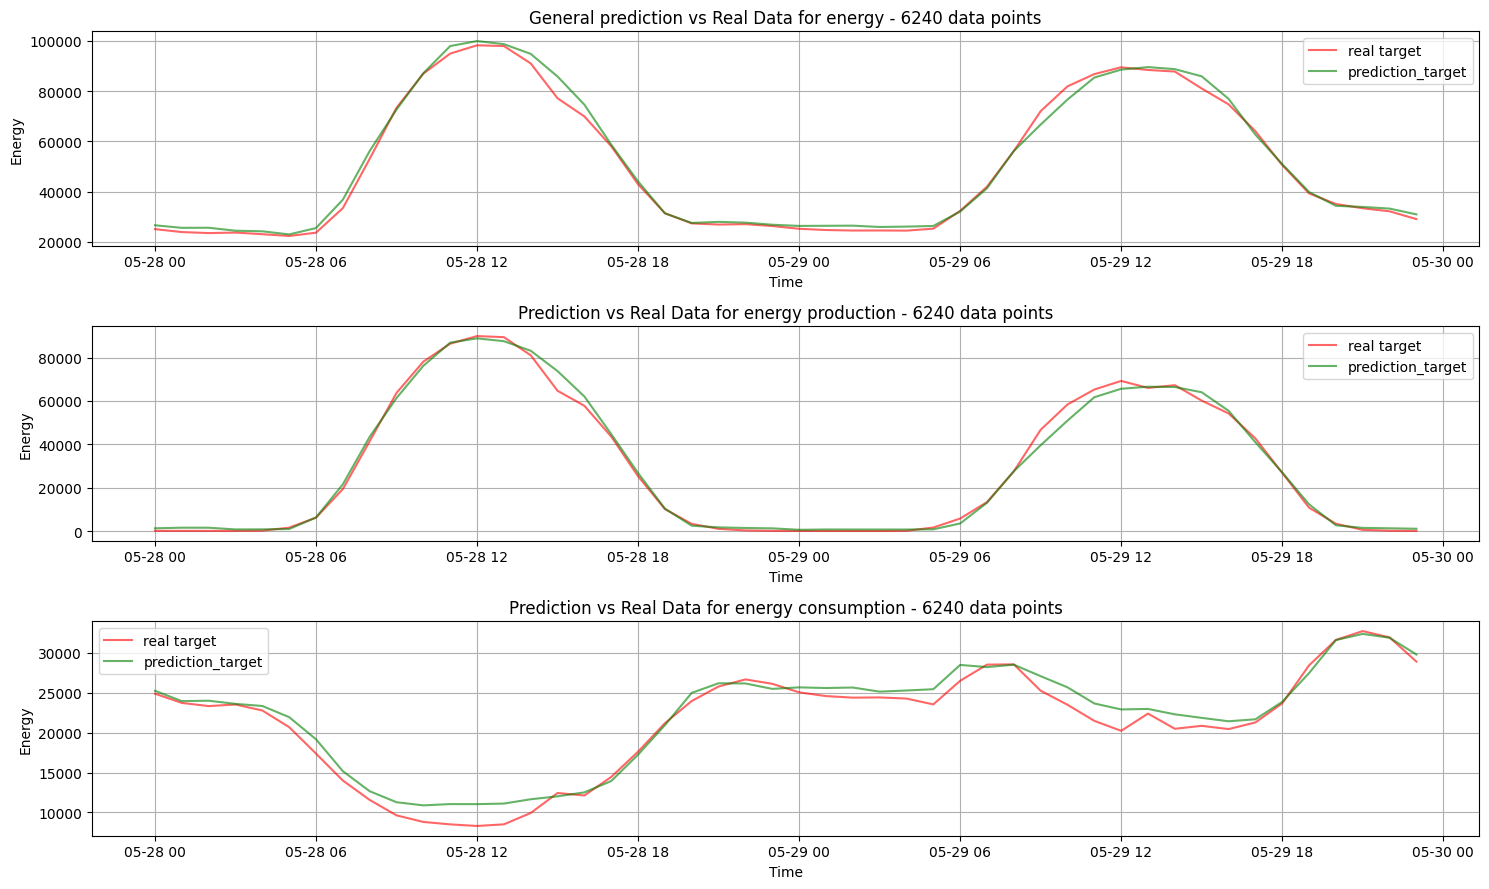

In [687]:
import matplotlib.pyplot as plt

fig, (ax,ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 9))

number_data_points = len(df_revealed)

# First graph
ax.plot(df_prediction_grouped['target'], label='real target', color='r', alpha=0.6)
ax.plot(df_prediction_grouped['prediction_target'], label='prediction_target', color='g', alpha=0.6)
ax.set_title(f'General prediction vs Real Data for energy - {number_data_points} data points')
ax.set_xlabel('Time')
ax.set_ylabel('Energy')
ax.grid()
ax.legend()

# Second graph
ax1.plot(df_prediction_production_grouped['target'], label='real target', color='r', alpha=0.6)
ax1.plot(df_prediction_production_grouped['prediction_target'], label='prediction_target', color='g', alpha=0.6)
ax1.set_title(f'Prediction vs Real Data for energy production - {number_data_points} data points')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy')
ax1.grid()
ax1.legend()

# Third graph
ax2.plot(df_prediction_consumption_grouped['target'], label='real target', color='r', alpha=0.6)
ax2.plot(df_prediction_consumption_grouped['prediction_target'], label='prediction_target', color='g', alpha=0.6)
ax2.set_title(f'Prediction vs Real Data for energy consumption - {number_data_points} data points')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

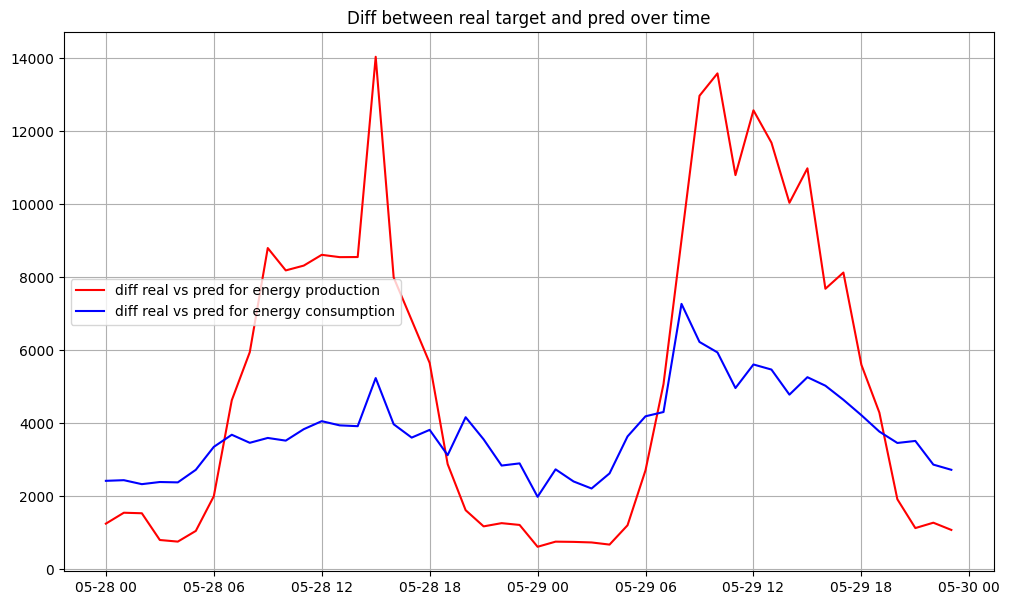

In [666]:
plt.figure(figsize=(12,7))

plt.plot(df_prediction_production_grouped['diff_target'], label='diff real vs pred for energy production', color='r')
plt.plot(df_prediction_consumption_grouped['diff_target'], label='diff real vs pred for energy consumption', color='b')

plt.title('Diff between real target and pred over time')
plt.legend()
plt.grid()
plt.show()

##

# 5 - Study the prediction for leftover from train set (30% of the train set)

In [682]:
y_pred_from_leftovertrain_serie = pd.Series(y_pred_from_leftovertrain, name='y_pred')
y_test_serie = pd.Series(y_test, name='y_true')
y_pred_from_leftovertrain_serie.index = X_test.index
y_test_serie.index = X_test.index

df_leftovertrain = pd.concat([X_test, y_pred_from_leftovertrain_serie,y_test_serie], axis=1)
df_leftovertrain['datetime'] = pd.to_datetime(df_leftovertrain[['year', 'month', 'day', 'hour']].assign(minute=0, second=0))

## 5.1 - General view

In [693]:
# Calculate the difference between the prediction and the real target
df_leftovertrain['diff_target'] = np.abs(df_leftovertrain['y_pred'] - df_leftovertrain['y_true'])

# Create 2 dataframes, one for the consumption and one for the production
df_leftovertrain_consumption = df_leftovertrain[df_leftovertrain['is_consumption']==1]
df_leftovertrain_production = df_leftovertrain[df_leftovertrain['is_consumption']==0]

# Group the data per date
df_leftovertrain_grouped = df_leftovertrain.groupby(by='datetime').sum()
df_leftovertrain_consumption_grouped = df_leftovertrain_consumption.groupby(by='datetime').sum()
df_leftovertrain_production_grouped = df_leftovertrain_production.groupby(by='datetime').sum()

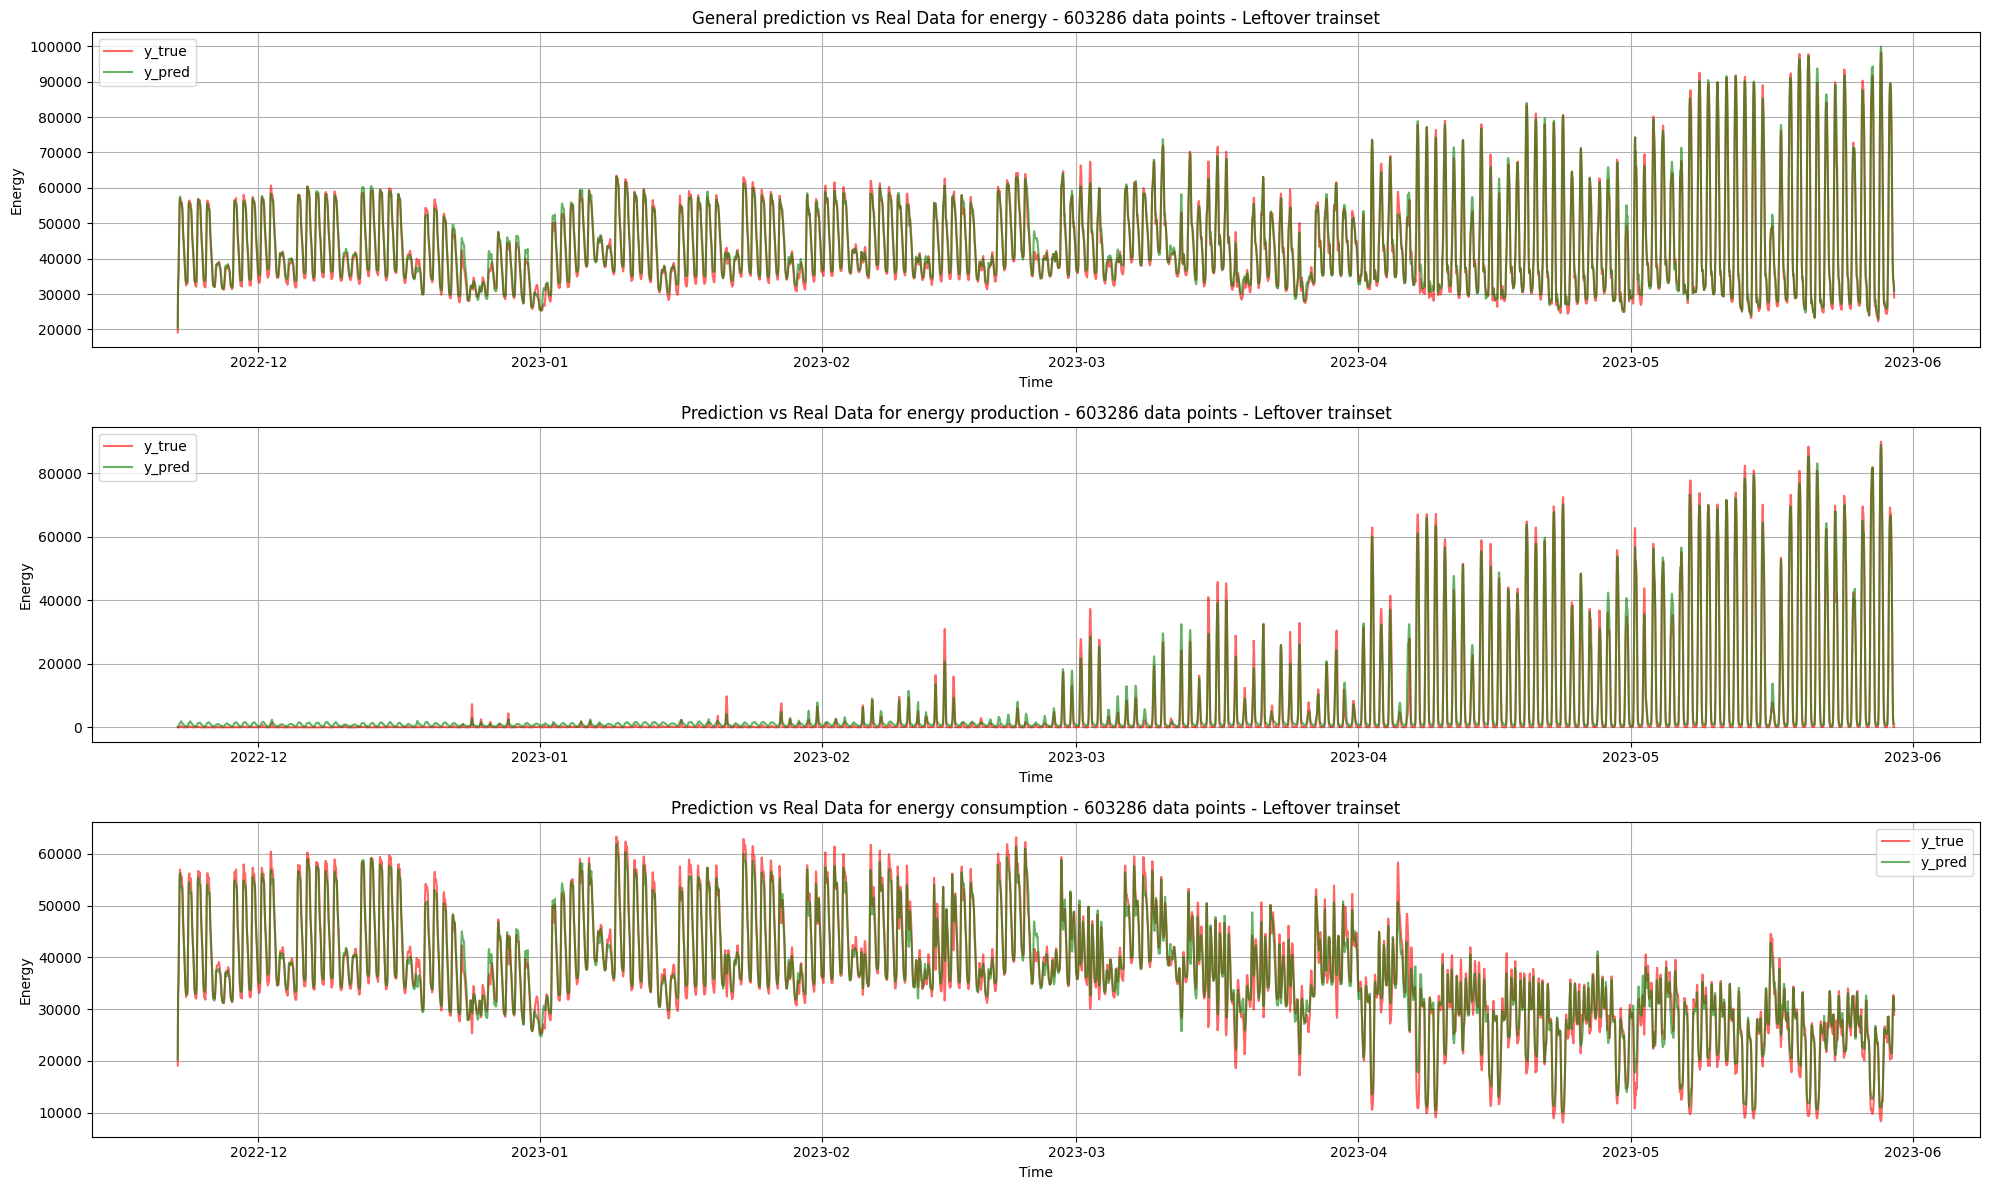

In [696]:
import matplotlib.pyplot as plt

fig, (ax,ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))

number_data_points = len(df_leftovertrain)

# First graph
ax.plot(df_leftovertrain_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax.plot(df_leftovertrain_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax.set_title(f'General prediction vs Real Data for energy - {number_data_points} data points - Leftover trainset')
ax.set_xlabel('Time')
ax.set_ylabel('Energy')
ax.grid()
ax.legend()

# Second graph
ax1.plot(df_leftovertrain_production_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax1.plot(df_leftovertrain_production_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax1.set_title(f'Prediction vs Real Data for energy production - {number_data_points} data points - Leftover trainset')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy')
ax1.grid()
ax1.legend()

# Third graph
ax2.plot(df_leftovertrain_consumption_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax2.plot(df_leftovertrain_consumption_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax2.set_title(f'Prediction vs Real Data for energy consumption - {number_data_points} data points - Leftover trainset')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

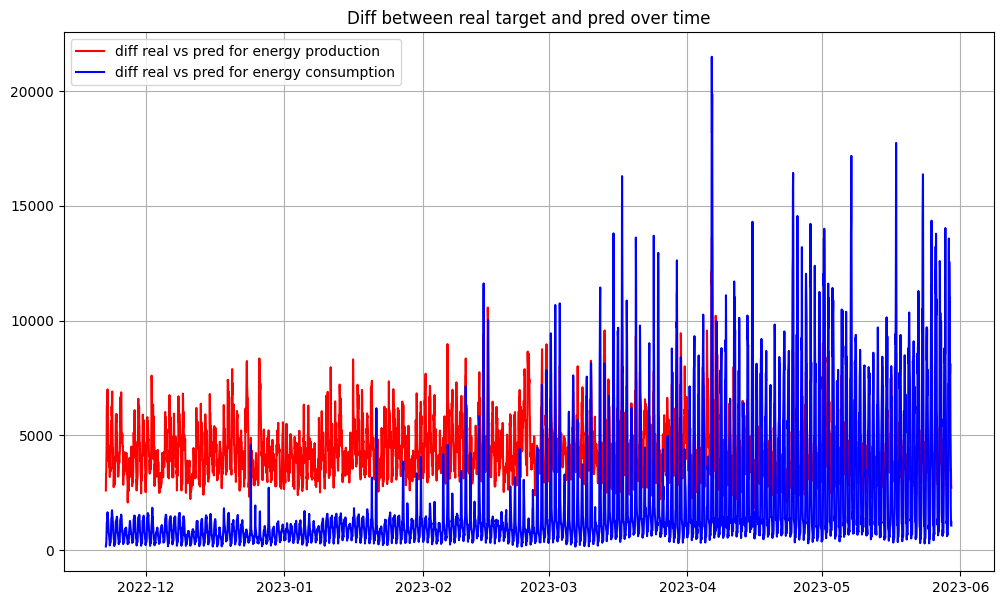

In [700]:
plt.figure(figsize=(12,7))

plt.plot(df_leftovertrain_consumption_grouped['diff_target'], label='diff real vs pred for energy production', color='r')
plt.plot(df_leftovertrain_production_grouped['diff_target'], label='diff real vs pred for energy consumption', color='b')

plt.title('Diff between real target and pred over time')
plt.legend()
plt.grid()
plt.show()

## 5.2 - Focus on one month - April

In [699]:
df_leftovertrain_focus = df_leftovertrain.loc[df_leftovertrain['month'] == 4]

In [701]:
# Calculate the difference between the prediction and the real target
df_leftovertrain_focus['diff_target'] = np.abs(df_leftovertrain_focus['y_pred'] - df_leftovertrain_focus['y_true'])

# Create 2 dataframes, one for the consumption and one for the production
df_leftovertrain_focus_consumption = df_leftovertrain_focus[df_leftovertrain_focus['is_consumption']==1]
df_leftovertrain_focus_production = df_leftovertrain_focus[df_leftovertrain_focus['is_consumption']==0]

# Group the data per date
df_leftovertrain_focus_grouped = df_leftovertrain_focus.groupby(by='datetime').sum()
df_leftovertrain_consumption_focus_grouped = df_leftovertrain_focus_consumption.groupby(by='datetime').sum()
df_leftovertrain_production_focus_grouped = df_leftovertrain_focus_production.groupby(by='datetime').sum()

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_65043/1586898615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leftovertrain_focus['diff_target'] = np.abs(df_leftovertrain_focus['y_pred'] - df_leftovertrain_focus['y_true'])


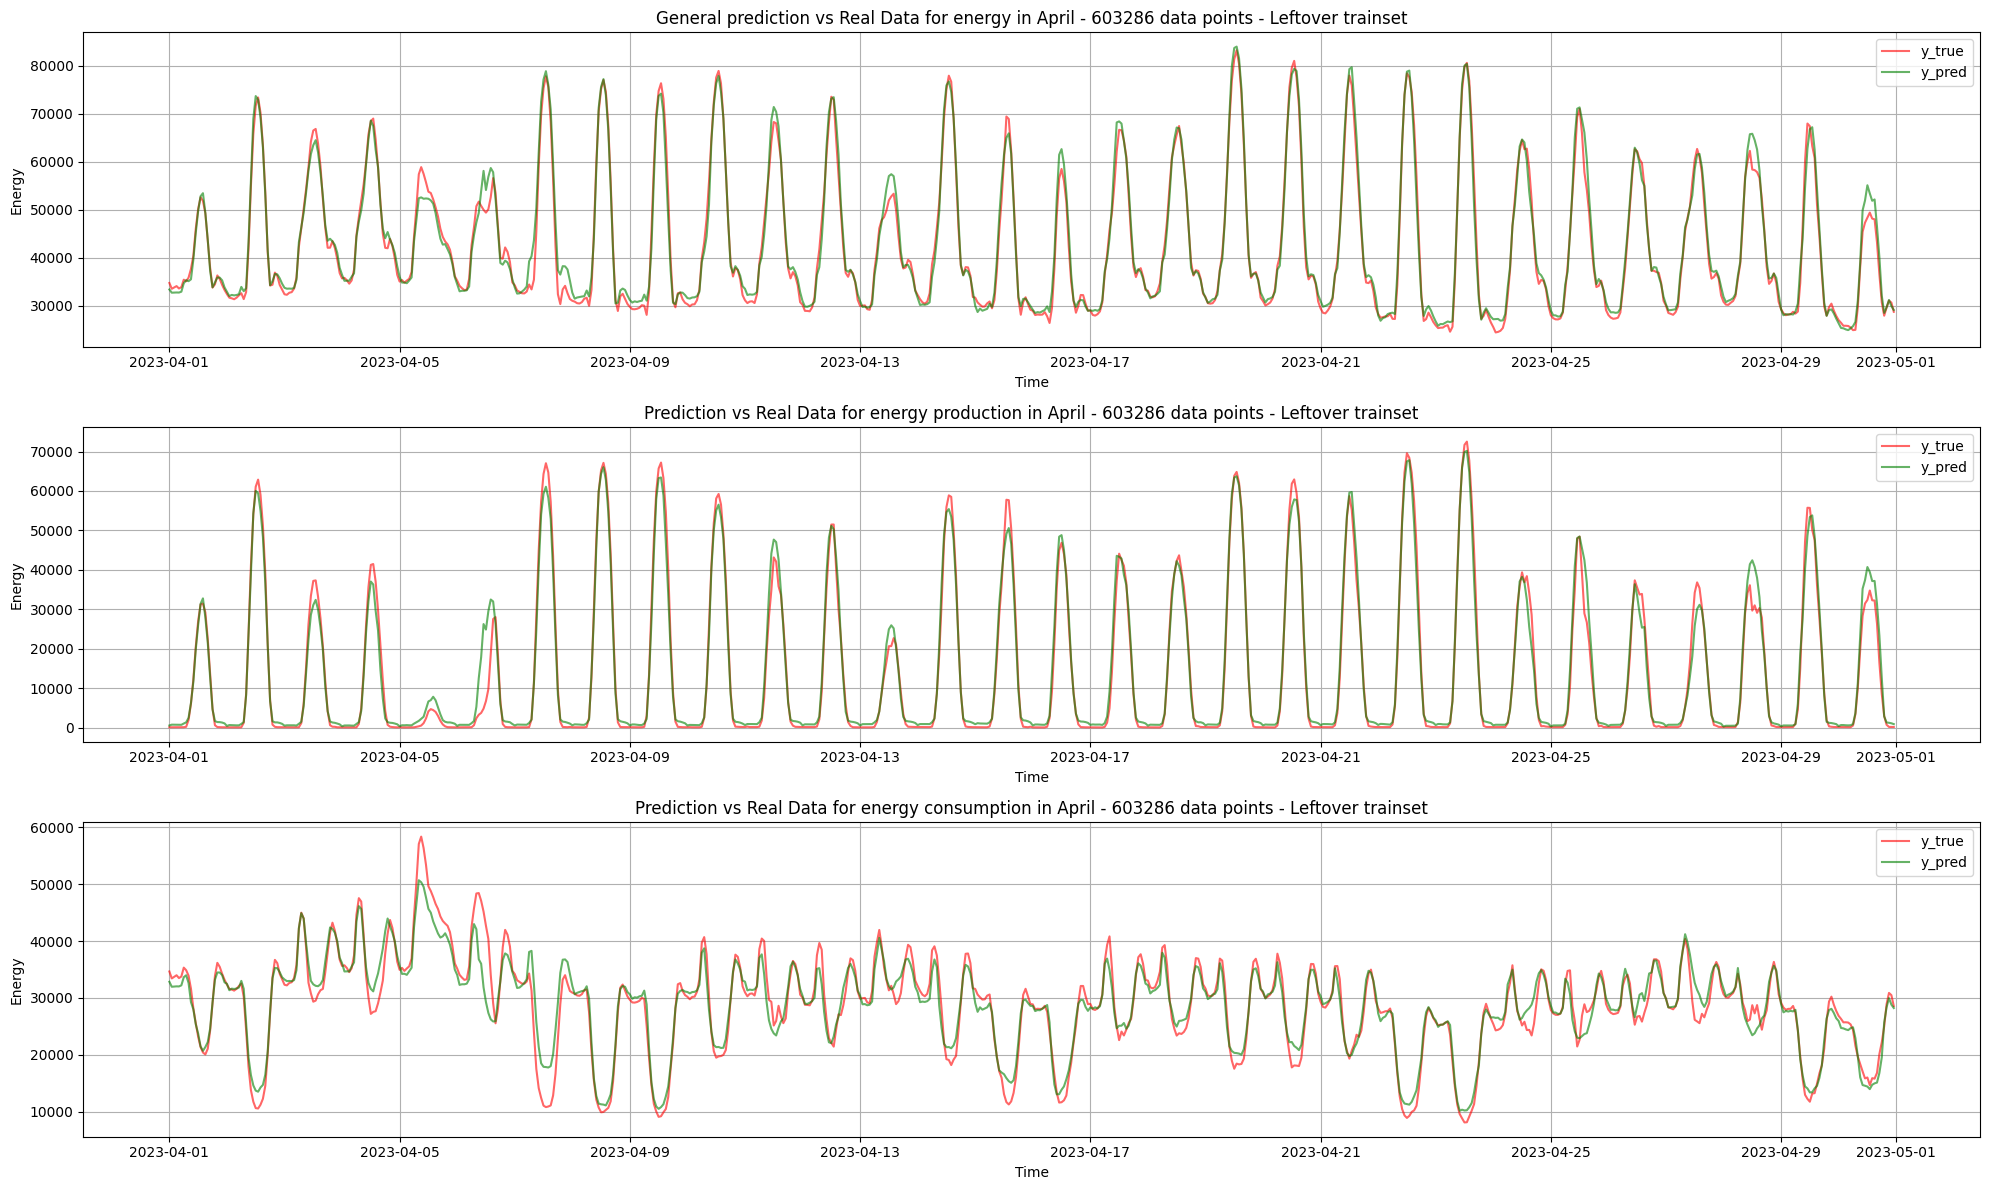

In [704]:
import matplotlib.pyplot as plt

fig, (ax,ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))

number_data_points = len(df_leftovertrain)

# First graph
ax.plot(df_leftovertrain_focus_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax.plot(df_leftovertrain_focus_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax.set_title(f'General prediction vs Real Data for energy in April - {number_data_points} data points - Leftover trainset')
ax.set_xlabel('Time')
ax.set_ylabel('Energy')
ax.grid()
ax.legend()

# Second graph
ax1.plot(df_leftovertrain_production_focus_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax1.plot(df_leftovertrain_production_focus_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax1.set_title(f'Prediction vs Real Data for energy production in April - {number_data_points} data points - Leftover trainset')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy')
ax1.grid()
ax1.legend()

# Third graph
ax2.plot(df_leftovertrain_consumption_focus_grouped['y_true'], label='y_true', color='r', alpha=0.6)
ax2.plot(df_leftovertrain_consumption_focus_grouped['y_pred'], label='y_pred', color='g', alpha=0.6)
ax2.set_title(f'Prediction vs Real Data for energy consumption in April - {number_data_points} data points - Leftover trainset')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

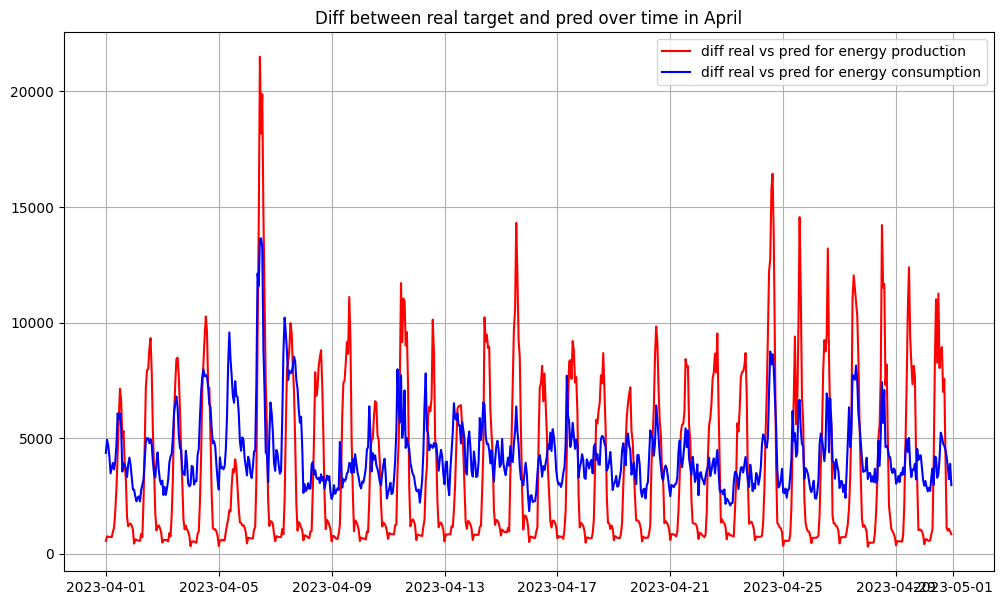

In [706]:
plt.figure(figsize=(12,7))

plt.plot(df_leftovertrain_production_focus_grouped['diff_target'], label='diff real vs pred for energy production', color='r')
plt.plot(df_leftovertrain_consumption_focus_grouped['diff_target'], label='diff real vs pred for energy consumption', color='b')

plt.title('Diff between real target and pred over time in April')
plt.legend()
plt.grid()
plt.show()